### Tabular Data

In general with tabular data, I like to blend GBDT and NN. Then I try adding a few ML models like SVR, LR, KNN, etc. Furthermore in Kaggle playground competitions, we must decide how to use the original dataset that synthetic data was created from.


### Feature Engineering

When train data is small (few rows) I do little or no feature engineering because it is easy to overfit train data. When data is large (many rows like December and February playground comps), I do lots of feature engineering.


In this competition, I chose to do no feature engineering. My solution is just an equal average of multiple models where each model trains on the data "as is" without feature engineering. So in this competition, I spent my time training different diverse models (using original data in different ways). And evaluating local ensemble OOF CV scores using Group K Fold. (And each ensemble uses equal weight averaging to avoid ensemble overfit).

In [1]:
%reload_ext cudf.pandas

import os
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
train, test = pd.read_csv('data/train.csv'), pd.read_csv('data/test.csv')

train.shape, test.shape # Extremely small dataset for feature engineering

((2190, 13), (730, 12))

In [3]:
train.info()    # All numerical features

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   id             2190 non-null   int64
 1   day            2190 non-null   int64
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64
dtypes: float64(10), int64(3)
memory usage: 222.4 KB


In [4]:
train.describe()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
count,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000
mean,1094.500000,179.948402,1013.602146,26.365799,23.953059,22.170091,20.454566,82.036530,75.721918,3.744429,104.863151,21.804703,0.753425
std,632.342866,105.203592,5.655366,5.654330,5.222410,5.059120,5.288406,7.800654,18.026498,3.626327,80.002416,9.898659,0.431116
min,0.000000,1.000000,999.000000,10.400000,7.400000,4.000000,-0.300000,39.000000,2.000000,0.000000,10.000000,4.400000,0.000000
25%,547.250000,89.000000,1008.600000,21.300000,19.300000,17.700000,16.800000,77.000000,69.000000,0.400000,40.000000,14.125000,1.000000
50%,1094.500000,178.500000,1013.000000,27.800000,25.500000,23.850000,22.150000,82.000000,83.000000,2.400000,70.000000,20.500000,1.000000
75%,1641.750000,270.000000,1017.775000,31.200000,28.400000,26.400000,25.000000,88.000000,88.000000,6.800000,200.000000,27.900000,1.000000
max,2189.000000,365.000000,1034.600000,36.000000,31.500000,29.800000,26.700000,98.000000,100.000000,12.100000,300.000000,59.500000,1.000000


In [5]:
train.isna().sum()  # No NaNs

id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
rainfall         0
dtype: int64

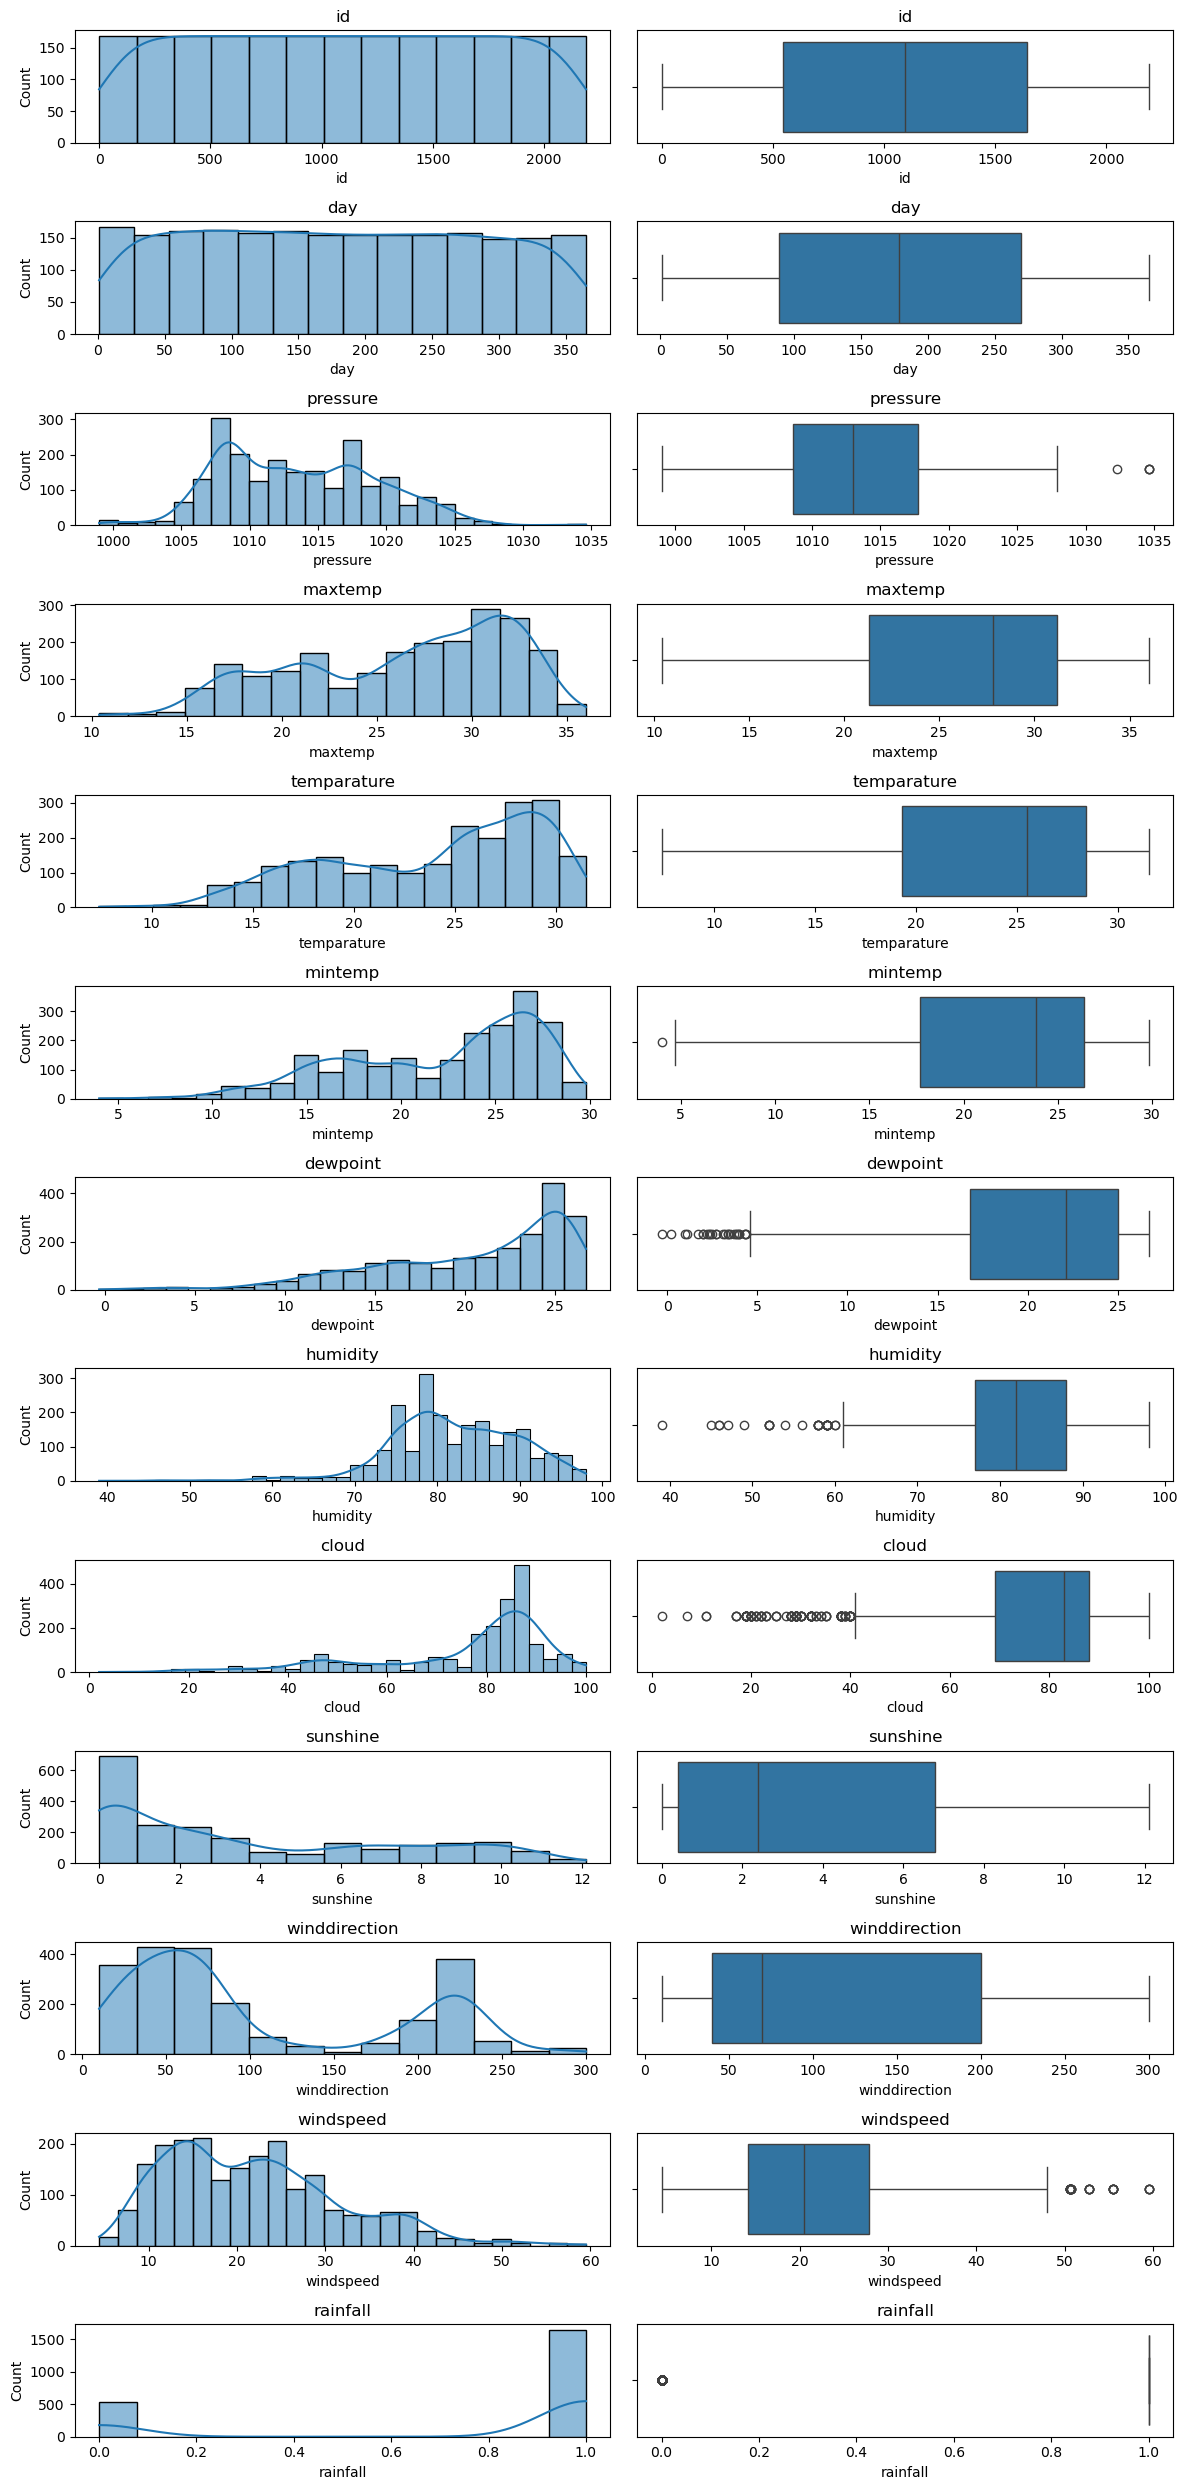

In [6]:

NUM_COLS = train.select_dtypes(include=[np.number]).columns.tolist()

# Subplots for visualizing the distribution of numerical features
fig, axes = plt.subplots(len(NUM_COLS), 2, figsize=(12, 25))
axes = axes.flatten()
for i, col in enumerate(NUM_COLS):
    sns.histplot(train[col], kde=True, ax=axes[2 * i])
    axes[2 * i].set_title(col)

    sns.boxplot(train[col], ax=axes[2 * i + 1], orient='h')
    axes[2 * i + 1].set_title(col)


plt.tight_layout()
plt.show()


### Group K Fold

In this competition, I used Group K Fold with 6 folds. I split the train data into 6 years and put each year in its own fold using Group K Fold. Because the test data is two new years of data

In [7]:
train['id'] // 365

0       0
1       0
2       0
3       0
4       0
       ..
2185    5
2186    5
2187    5
2188    5
2189    5
Name: id, Length: 2190, dtype: int64

In [8]:
train.columns

Index(['id', 'day', 'pressure', 'maxtemp', 'temparature', 'mintemp',
       'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection',
       'windspeed', 'rainfall'],
      dtype='object')

## [XGBoost Starter Ensemble [0.883 CV]](https://www.kaggle.com/code/cdeotte/xgboost-starter-ensemble-lb-0-935-wow)

In [9]:
import xgboost

from sklearn.model_selection import KFold 
from xgboost import XGBClassifier, XGBRegressor

xgboost.__version__

'2.1.2'

In [10]:
%%time

FOLDS=5
FEATURES = [col for col in NUM_COLS if col not in set(['id', 'rainfall'])]

kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_xgb = np.zeros(len(train))
pred_xgb = np.zeros(len(test))

for i, (train_idx, test_idx) in enumerate(kf.split(train)):
    print("#" * 20)
    print(f'FOLD {i+1}')
    print("#" * 20)

    X_train, y_train = train.loc[train_idx, FEATURES].copy(), train.loc[train_idx, 'rainfall']
    X_val, y_val = train.loc[test_idx, FEATURES].copy(), train.loc[test_idx, 'rainfall']

    X_test = test[FEATURES].copy()

    xgb_model = XGBClassifier(
        device='cuda',
        n_estimators=10_000,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric='auc',
        early_stopping_rounds=100,
        alpha=1
    )

    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)

    oof_xgb[test_idx] = xgb_model.predict_proba(X_val)[:, 1]
    pred_xgb += xgb_model.predict_proba(X_test)[:, 1]


pred_xgb /= FOLDS

####################
FOLD 1
####################
[0]	validation_0-auc:0.81544
[100]	validation_0-auc:0.86196
[160]	validation_0-auc:0.85867
####################
FOLD 2
####################


/home/tufboi69/miniconda3/envs/eda-gpu/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:00:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1732221635527/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.86738
[100]	validation_0-auc:0.87590
[118]	validation_0-auc:0.87178
####################
FOLD 3
####################
[0]	validation_0-auc:0.82672
[100]	validation_0-auc:0.90518
[177]	validation_0-auc:0.90097
####################
FOLD 4
####################
[0]	validation_0-auc:0.88918
[100]	validation_0-auc:0.91585
[132]	validation_0-auc:0.91348
####################
FOLD 5
####################
[0]	validation_0-auc:0.83912
[100]	validation_0-auc:0.88168
[148]	validation_0-auc:0.87973
CPU times: user 54.7 s, sys: 2.49 s, total: 57.2 s
Wall time: 5.66 s


In [11]:
from sklearn.metrics import roc_auc_score
true = train.rainfall.values
m = roc_auc_score(true, oof_xgb)
print(f"XGBoost CV Score AUC = {m:.3f}")

XGBoost CV Score AUC = 0.883


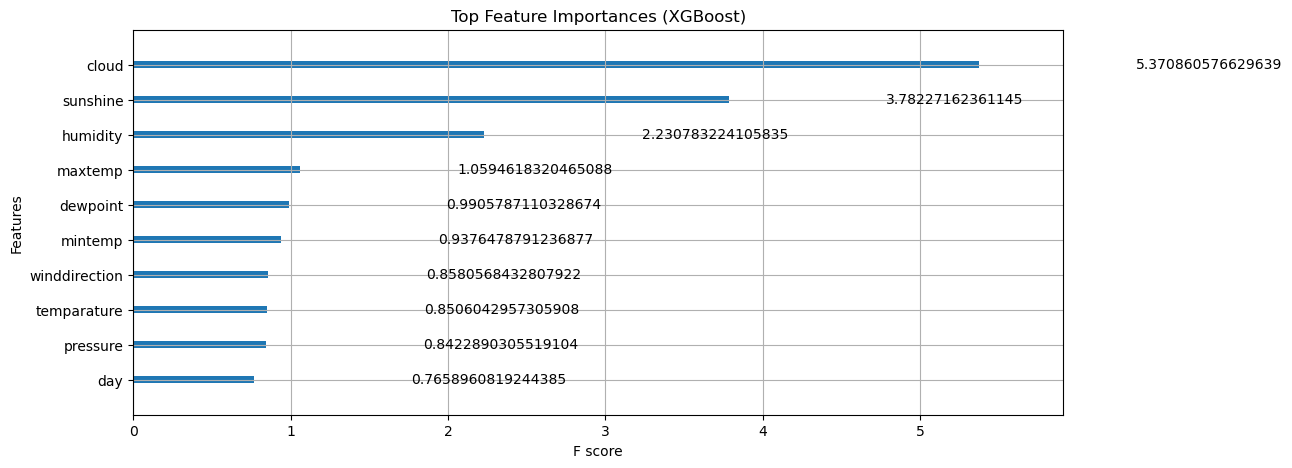

In [12]:
fig, ax = plt.subplots(figsize=(12, 5))
xgboost.plot_importance(xgb_model, max_num_features=10, importance_type='gain', ax=ax)
plt.title("Top Feature Importances (XGBoost)")
plt.show()

## [RAPIDS SVC w/ Feature Engineering - [LB 0.856]](https://www.kaggle.com/code/cdeotte/rapids-svc-w-feature-engineering-lb-0-856)

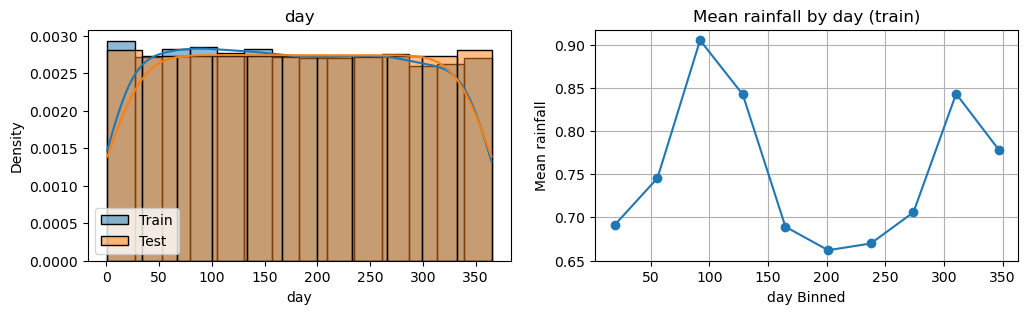

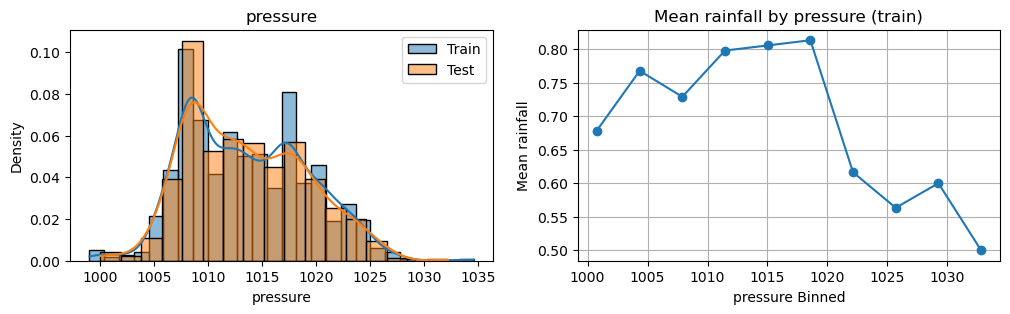

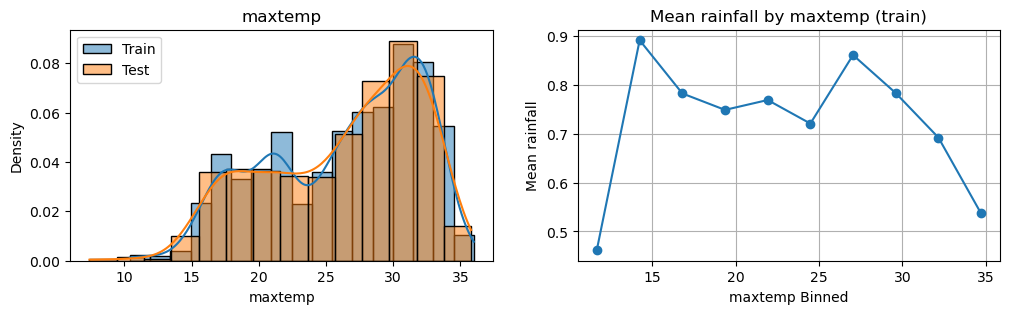

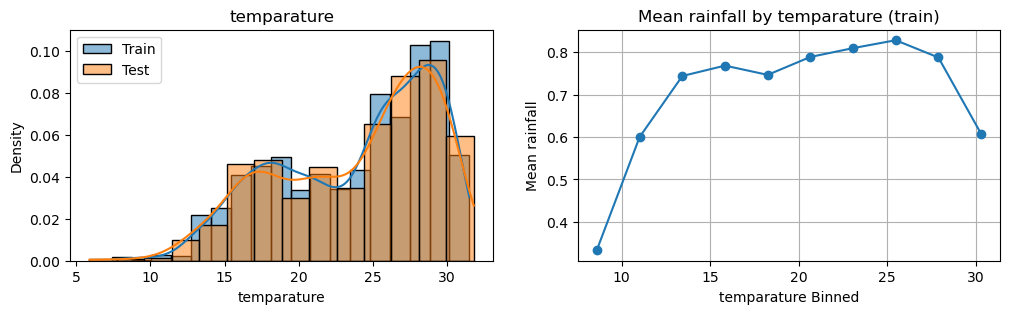

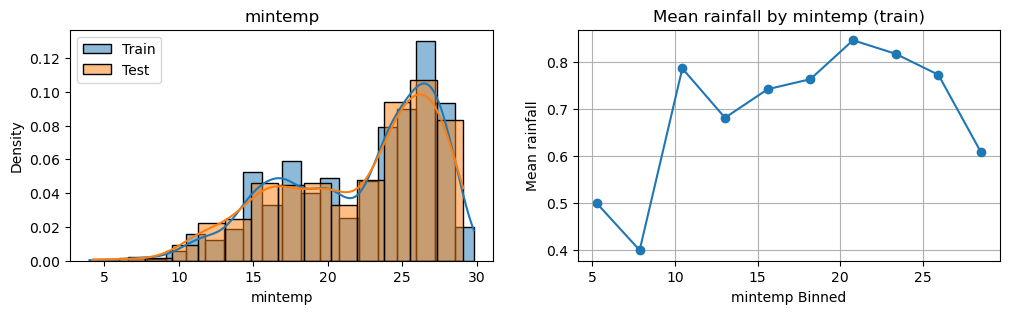

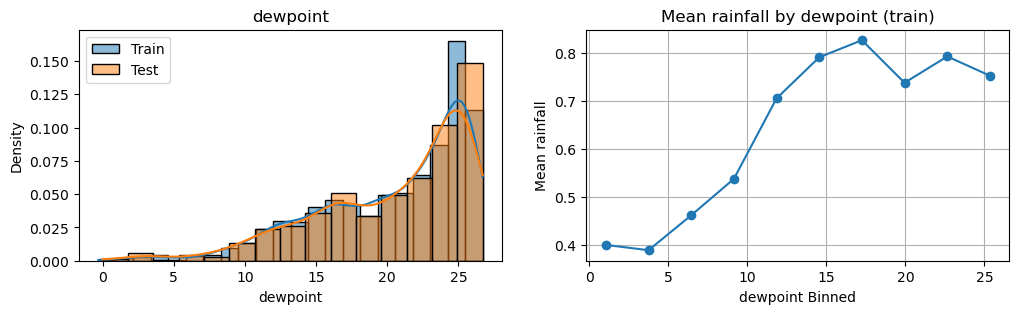

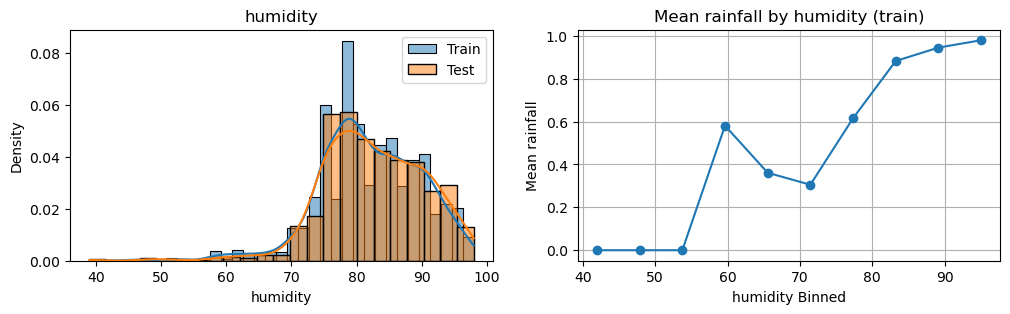

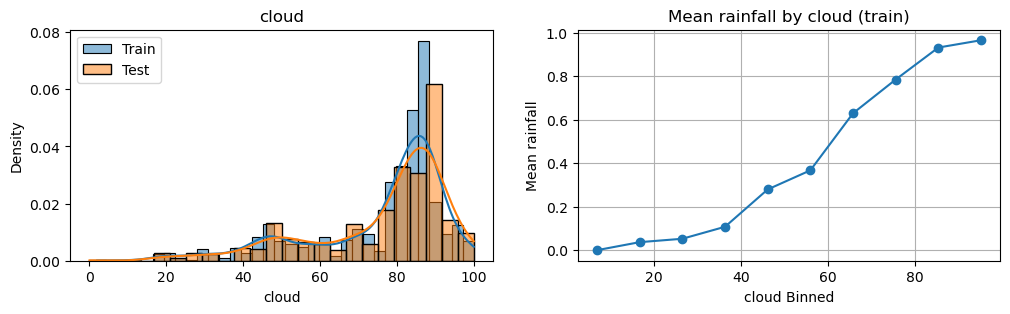

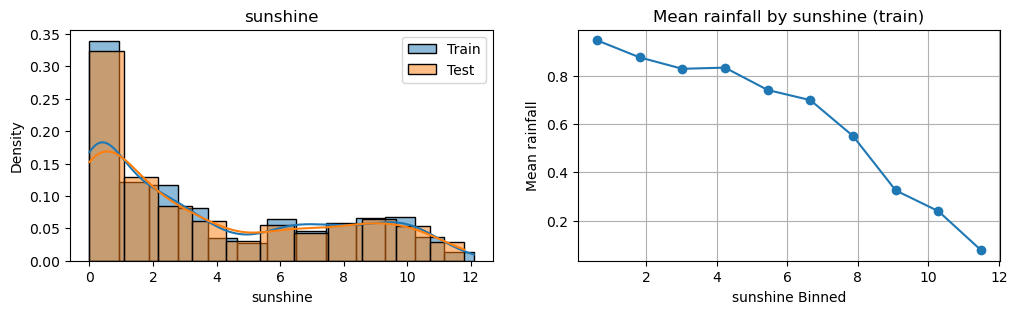

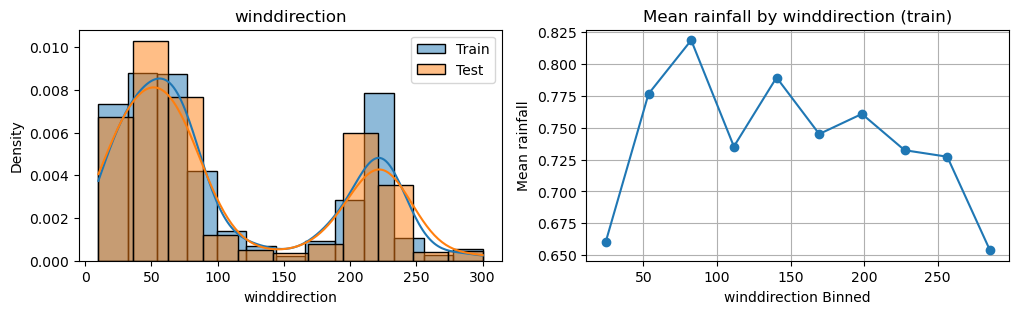

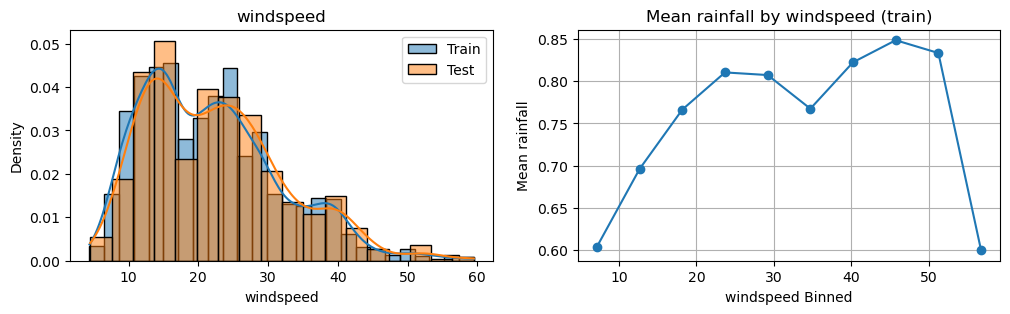

In [13]:
for col in FEATURES:
    plt.figure(figsize=(12, 3))

    # Plot train and test distributions for each numerical feature

    plt.subplot(1, 2, 1)
    sns.histplot(data=train, x=col, kde=True, stat='density', label='Train')
    sns.histplot(data=test, x=col, kde=True, stat='density', label='Test')
    plt.legend()
    plt.title(f'{col}')


    # Plot target relationship with binned numerical feature
    plt.subplot(1, 2, 2)
    train['bucket'], bin_edges = pd.cut(train[col], bins=10, retbins=True, labels=False)
    bucket_means = train.groupby('bucket')['rainfall'].mean()
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(bin_midpoints, bucket_means, marker='o', linestyle='-')
    plt.xlabel(f'{col} Binned')
    plt.ylabel('Mean rainfall')
    plt.title(f'Mean rainfall by {col} (train)')
    plt.grid()
    plt.show()

### RAPIDS SVC w/ Forward Feature Selection

Using the speed up GPU we will iterate though a list of engineered features and train a new model with adding each one by one to our basic features. Whenever a new feature improves our CV score, we will keep it and continue. If the feature does not improve CV score, we will discard it.

Note the model SVC wants all features to have mean=0 and std=1, so we standardize all features inside each of our k fold loops. Since the data is small, we will cautiously avoid overfitting by using a linear SVC model (and we are selectively adding some non-linear engineered features).


In [14]:
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import roc_auc_score
# from cuml.svm import SVC, LinearSVC
from sklearn.svm import SVC, LinearSVC

In [15]:
train['year_group'] = train.id // 365
train.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,bucket,year_group
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1,2,0
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1,3,0
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1,2,0
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1,5,0
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0,3,0


In [16]:
FEATURES

['day',
 'pressure',
 'maxtemp',
 'temparature',
 'mintemp',
 'dewpoint',
 'humidity',
 'cloud',
 'sunshine',
 'winddirection',
 'windspeed']

In [17]:
PAIRS = []

for i, col1 in enumerate(FEATURES[:-1]):
    for j, col2 in enumerate(FEATURES[i+1:]):
        new_col = f"{col1}_{col2}"
        train[new_col] = train[col1] * train[col2]
        test[new_col] = test[col1] * test[col2]
        PAIRS.append(new_col)

print(f"There are {len(PAIRS)} interacting features.")

There are 55 interacting features.


In [18]:
ADD = []
best_auc = 0
best_oof = best_pred = None

# Forward Featrure Selection
for k, col in enumerate(['baseline'] + PAIRS):

    FOLDS = train.year_group.nunique()
    kf = GroupKFold(n_splits=FOLDS)

    oof_svc = np.zeros(train.shape[0])
    pred_svc = np.zeros(test.shape[0])

    if col != 'baseline': ADD.append(col)

    for i, (train_idx, test_idx) in enumerate(kf.split(train, groups=train.year_group)):

        X_train, y_train = train.loc[train_idx, FEATURES + ADD].copy(), train.loc[train_idx, 'rainfall']
        X_val, y_val = train.loc[test_idx, FEATURES + ADD].copy(), train.loc[test_idx, 'rainfall']
        X_test = test.loc[:, FEATURES + ADD].copy()

        # SVC needs standardized features. 
        for col in FEATURES + ADD:
            mean = X_train[col].mean()
            std = X_train[col].std()
            X_train[col] = (X_train[col] - mean) / std
            X_val[col] = (X_val[col] - mean) / std
            X_test[col] = (X_test[col] - mean) / std
            X_test[col] = X_test[col].fillna(0)


        # model = SVC(C=0.1, probability=True, kernel='poly', degree=1, random_state=42)
        model = LinearSVC(C=0.1)
        model.fit(X_train.values, y_train.values)
        
        oof_svc[test_idx] = model.predict(X_val.values)
        pred_svc += model.predict(X_test.values)
    
    pred_svc /= FOLDS

    true = train.rainfall.values
    m = roc_auc_score(true, oof_svc)

    if m > best_auc:
        print(f'NEW BEST AUC with {col} at {m}')
        best_auc = m
        best_oof = oof_svc.copy()
        best_pred = pred_svc.copy()
    else:
        print(f"Worse AUC with {col} at {m}")
        ADD.remove(col)

NEW BEST AUC with windspeed at 0.7903703703703704
Worse AUC with day_pressure at 0.7903703703703704
Worse AUC with day_maxtemp at 0.7894444444444444
Worse AUC with day_temparature at 0.7891414141414141
NEW BEST AUC with day_mintemp at 0.7912962962962962
Worse AUC with day_dewpoint at 0.790976430976431
NEW BEST AUC with day_humidity at 0.7915993265993266
Worse AUC with day_cloud at 0.7915993265993266
Worse AUC with day_sunshine at 0.7885185185185186
Worse AUC with day_winddirection at 0.7888383838383838
Worse AUC with day_windspeed at 0.7885185185185186
Worse AUC with pressure_maxtemp at 0.7915993265993266
Worse AUC with pressure_temparature at 0.7915993265993266
Worse AUC with pressure_mintemp at 0.790993265993266
Worse AUC with pressure_dewpoint at 0.7915993265993266
Worse AUC with pressure_humidity at 0.7915993265993266
Worse AUC with pressure_cloud at 0.7903703703703704
Worse AUC with pressure_sunshine at 0.7912962962962962
Worse AUC with pressure_winddirection at 0.7915993265993266

In [20]:
print(f"We achieved CV SVC AUC = {best_auc:.4f} adding {len(ADD)} interactions features:")
print( ADD )

We achieved CV SVC AUC = 0.7925 adding 4 interactions features:
['day_mintemp', 'day_humidity', 'maxtemp_temparature', 'humidity_windspeed']
